# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

__Note:__ Let's make sure we import the right modules

In [1]:
import os
import cv2   
import numpy as np
import torch
import time

import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
from glob import glob
from torch import nn, optim
from torchvision import datasets
from PIL import Image, ImageFile
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
ImageFile.LOAD_TRUNCATED_IMAGES = True

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:

**Note: if you are using the Udacity workspace, you *DO NOT* need to re-download these - they can be found in the `/data` folder as noted in the cell below.**

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [2]:
# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


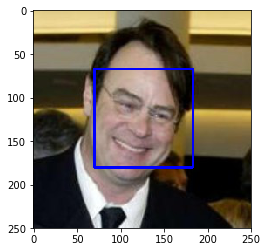

In [3]:
# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])

# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector_alt(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ Using "haarcascade_frontalface_alt.xml" face detector:
- Percentage of positive cases in human_files: 98%
- Percentage of positive cases in dog_files: 17%

In [5]:
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]
#-#-# Do NOT modify the code above this line. #-#-#

In [6]:
## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

def run_face_detector_test(detector, human_filelist, dog_filelist):
    human_detect = []
    dog_detect = []

    for file in human_filelist:
        human_detect.append(int(detector(file)))

    for file in dog_filelist:
        dog_detect.append(int(detector(file)))
        
    predictions = human_detect+dog_detect
    
    #build groundtruth
    human_ground_truth = [1]*len(human_detect)
    dog_ground_truth = [0]*len(dog_detect)
    ground_truths = human_ground_truth+dog_ground_truth
    
    metrics = precision_recall_fscore_support(ground_truths, predictions)
    precision = np.mean(metrics[0])
    recall = np.mean(metrics[1])
    f1_score =  np.mean(metrics[2])
    accuracy = accuracy_score(ground_truths, predictions)
    
    print("Total accuracy: {}".format(accuracy))
    print("Total precision: {}".format(precision))
    print("Total recall: {}".format(recall))
    print("Total F1 score: {}".format(f1_score))
    
    print("Percentage of positive cases in human list: {}".format(sum(human_detect)/len(human_detect)))
    print("Percentage of positive cases in dog list: {}".format(sum(dog_detect)/len(dog_detect)))

In [7]:
run_face_detector_test(face_detector_alt, human_files_short, dog_files_short)

Total accuracy: 0.905
Total precision: 0.9143222506393862
Total recall: 0.905
Total F1 score: 0.9044626021370207
Percentage of positive cases in human list: 0.98
Percentage of positive cases in dog list: 0.17


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [8]:
### (Optional) 
### TODO: Test performance of anotherface detection algorithm.
### Feel free to use as many code cells as needed.

### Optional

We tested "haarcascade_frontalface_alt2" face detection as an alternative. We observe the following results in the first 500 images of each:

__"haarcascade_frontalface_alt"__
- Percentage of positive cases in human_files: 98.6%
- Percentage of positive cases in dog_files: 11.8%


__"haarcascade_frontalface_alt2"__
- Percentage of positive cases in human_files: 99.6%
- Percentage of positive cases in dog_files: 21.4%

In [9]:
face_cascade_2 = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt2.xml')

def face_detector_alt2(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade_2.detectMultiScale(gray)
    return len(faces) > 0

In [10]:
#allocate 500 images
human_files_short_500 = human_files[:500]
dog_files_short_500 = dog_files[:500]

In [11]:
%%time
#run vggface_detector_alt model on first 500 images
run_face_detector_test(face_detector_alt, human_files_short_500, dog_files_short_500)

Total accuracy: 0.934
Total precision: 0.9387454710144927
Total recall: 0.9339999999999999
Total F1 score: 0.9338210521249458
Percentage of positive cases in human list: 0.986
Percentage of positive cases in dog list: 0.118
CPU times: user 6min 4s, sys: 315 ms, total: 6min 5s
Wall time: 1min 38s


In [12]:
%%time
#run vgg-16 model on first 100 images
run_face_detector_test(face_detector_alt2, human_files_short_500, dog_files_short_500)

Total accuracy: 0.892
Total precision: 0.9104471360841668
Total recall: 0.892
Total F1 score: 0.890772722307851
Percentage of positive cases in human list: 0.998
Percentage of positive cases in dog list: 0.214
CPU times: user 5min 44s, sys: 641 ms, total: 5min 45s
Wall time: 1min 32s


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [13]:
# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:05<00:00, 98260863.93it/s] 


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [14]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model
        Args:
            img_path: path to an image
        Returns:
            Numpy array of size 3x224x224
    '''

    #open image path
    im = Image.open(image)
    
    #resize image where the shortest side is 256 pixels, keeping the aspect ratio
    size = (256,256)
    im.thumbnail(size)
    
    #crop out the center 224x224 portion of the image
    width, height = im.size
    im = im.crop(((width-224)/2, (height-224)/2, width-(width-224)/2, height-(height-224)/2))
    
    #convert to numpy array and model 0-1
    im = np.array(im)/255.0
    
    #normalize image
    mu = [0.485, 0.456, 0.406]
    sig = [0.229, 0.224, 0.225]
    np_norm = (im-mu)/sig
    
    #transpose image
    np_trans = np_norm.transpose((2, 0, 1))
    
    return np_trans

def torch_model_predict(model, img_path):
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    input_image = process_image(img_path)
    
    input_image = torch.from_numpy(np.array([input_image])).float()
    
    if torch.cuda.is_available():
        device = torch.device("cuda")
    
    model.eval()
    
    with torch.no_grad():
        
        input_image = input_image.to(device)
        log_output = model.forward(input_image)
        top_ps, top_idxs = log_output.topk(1, dim=1) 
    
    return top_idxs.to("cpu") # predicted class index

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [15]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(model, img_path):
    ## TODO: Complete the function.
    clss_idx = torch_model_predict(model, img_path)
    
    return 151 <= clss_idx <= 268 # true/false

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ We observe the following results in the first 100 images of each:

__"VGG-16"__
- Percentage of positive cases in human_files: 1%
- Percentage of positive cases in dog_files: 100%

In [16]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

def run_dog_detector_test(model, human_filelist, dog_filelist):
    
    #build predictions
    human_detect = []
    dog_detect = []

    for file in human_filelist:
        human_detect.append(int(dog_detector(model, file)))

    for file in dog_filelist:
        dog_detect.append(int(dog_detector(model, file)))

    predictions = human_detect+dog_detect
    
    #build groundtruth
    human_ground_truth = [0]*len(human_detect)
    dog_ground_truth = [1]*len(dog_detect)
    ground_truths = human_ground_truth+dog_ground_truth
    
    #get metrics
    metrics = precision_recall_fscore_support(ground_truths, predictions)
    precision = np.mean(metrics[0])
    recall = np.mean(metrics[1])
    f1_score =  np.mean(metrics[2])
    accuracy = accuracy_score(ground_truths, predictions)
    
    print("Total accuracy: {}".format(accuracy))
    print("Total precision: {}".format(precision))
    print("Total recall: {}".format(recall))
    print("Total F1 score: {}".format(f1_score))
    
    print("Percentage of positive cases in human list: {}".format(sum(human_detect)/len(human_detect)))
    print("Percentage of positive cases in dog list: {}".format(sum(dog_detect)/len(dog_detect)))

In [17]:
#run vgg-16 model on first 100 images
run_dog_detector_test(VGG16, human_files_short, dog_files_short)

Total accuracy: 0.995
Total precision: 0.995049504950495
Total recall: 0.995
Total F1 score: 0.9949998749968749
Percentage of positive cases in human list: 0.01
Percentage of positive cases in dog list: 1.0


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [18]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

### Optional

We tested "ResNet-50" and "DenseNet-121" dog detections as alternatives. We observe the following results in the first 500 images of each:

__"VGG-16"__
- Percentage of positive cases in human_files: 1.4%
- Percentage of positive cases in dog_files: 98%

__"ResNet-50"__
- Percentage of positive cases in human_files: 0.2%
- Percentage of positive cases in dog_files: 97.6%

__"DenseNet-121"__
- Percentage of positive cases in human_files: 0.4%
- Percentage of positive cases in dog_files: 95.8%

In [19]:
%%time
#run vgg-16 model on first 500 images
run_dog_detector_test(VGG16, human_files_short_500, dog_files_short_500)

Total accuracy: 0.983
Total precision: 0.9830173886259905
Total recall: 0.983
Total F1 score: 0.982999846998623
Percentage of positive cases in human list: 0.014
Percentage of positive cases in dog list: 0.98
CPU times: user 24.3 s, sys: 8.26 s, total: 32.5 s
Wall time: 32.5 s


In [20]:
# define resnet-50 model
RESNET = models.resnet50(pretrained=True)

# move model to GPU if CUDA is available
if use_cuda:
    RESNET = RESNET.cuda()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 76867897.79it/s]


In [21]:
%%time
#run resnet-50 model on first 500 images
run_dog_detector_test(RESNET, human_files_short_500, dog_files_short_500)

Total accuracy: 0.987
Total precision: 0.9872358221379147
Total recall: 0.987
Total F1 score: 0.9869984268096439
Percentage of positive cases in human list: 0.002
Percentage of positive cases in dog list: 0.976
CPU times: user 20.1 s, sys: 2.34 s, total: 22.4 s
Wall time: 22.4 s


In [22]:
# define densenet-121 model
DENSENET = models.densenet121(pretrained=True)

# move model to GPU if CUDA is available
if use_cuda:
    DENSENET = DENSENET.cuda()

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.torch/models/densenet121-a639ec97.pth
100%|██████████| 32342954/32342954 [00:00<00:00, 67334461.73it/s]


In [23]:
%%time
#run densenet-121 model on first 500 images
run_dog_detector_test(DENSENET, human_files_short_500, dog_files_short_500)

Total accuracy: 0.977
Total precision: 0.9776897840481655
Total recall: 0.977
Total F1 score: 0.9769916940015346
Percentage of positive cases in human list: 0.004
Percentage of positive cases in dog list: 0.958
CPU times: user 31.4 s, sys: 836 ms, total: 32.2 s
Wall time: 32.2 s


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [24]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

image_dir = "/data/dog_images/"
batch_size = 64

train_dir = os.path.join(image_dir,'train')
valid_dir = os.path.join(image_dir,'valid')
test_dir = os.path.join(image_dir,'test')

train_transforms = transforms.Compose([transforms.RandomRotation(40),
                                      transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                             [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                             [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                             [0.229, 0.224, 0.225])])

trainsets = datasets.ImageFolder(train_dir, transform = train_transforms)
validsets = datasets.ImageFolder(valid_dir, transform = valid_transforms)
testsets = datasets.ImageFolder(test_dir, transform = test_transforms)

trainloader = torch.utils.data.DataLoader(trainsets, batch_size=batch_size, shuffle=True)
validloader = torch.utils.data.DataLoader(validsets, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testsets, batch_size=batch_size)

loaders_scratch = {'train': trainloader, 'valid': validloader, 'test': testloader}

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:
- The code resizes the images by first resizing them to 256x256 and then center-cropping them to 224x224. Most of Pytorch popular pretrained models for image processing accept an input tensor of 3x224x224 (rgb size:3 + image size: 224x224). Thus, we decided to use the same input tensor size to leverage the pretrained models.
- It takes time and a very large image dataset to train a model as an image classifier. Augmenting the limited image dataset available will increase our model accuracy in identifying dog breeds in images. We are augmenting through random rotations, random cropping and random horizontal flips.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [25]:
# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        self.cv1 = nn.Conv2d(3,6,3,padding=1)
        self.pool1 = nn.MaxPool2d(2,2)
        self.cv2 = nn.Conv2d(6,12,3,padding=1)
        self.pool2 = nn.MaxPool2d(2,2)
        
        self.fc1 = nn.Linear(12*56*56,512)
        self.output = nn.Linear(512, 133)
        self.dropout = nn.Dropout(p=0.2)
        self.logsoftmax = nn.LogSoftmax(dim=1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        ## Define forward behavior
        x = self.cv1(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = self.cv2(x)
        x = self.relu(x)
        x = self.pool2(x)
        
        x = x.view(-1, 12*56*56)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.output(x)
        x = self.logsoftmax(x)
        
        return x

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()
    
model_scratch

Net(
  (cv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=37632, out_features=512, bias=True)
  (output): Linear(in_features=512, out_features=133, bias=True)
  (dropout): Dropout(p=0.2)
  (logsoftmax): LogSoftmax()
  (relu): ReLU()
)

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__

The convoluted feature dectector downsizes the image from 224x224 to 56x56 and increases its depth from 3 to 12, giving a total output size of 56x56x12. The convoluted output layer of size 56x56x12 is then fed into a multi-layered perceptron (37632, 512, 133), classifying the images within a 133 range.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [26]:
### TODO: select loss function
criterion_scratch = nn.NLLLoss()

### TODO: select optimizer
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=0.001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [27]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer.zero_grad()
                        
            output = model.forward(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        correct = 0.
        total = 0.
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            with torch.no_grad():
                output = model.forward(data)
                loss = criterion(output,target)
                
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            output = torch.exp(output)
            pred = output.data.max(1, keepdim=True)[1]
            # compare predictions to true label
            correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            total += data.size(0)
        
        # print training/validation statistics 
        print('\nEpoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        print('Validation Accuracy: %2d%% (%2d/%2d)' % (
            100. * correct / total, correct, total))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            print("Saved model")
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [28]:
%%time
# train the model
model_scratch = train(50, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')


Epoch: 1 	Training Loss: 4.969951 	Validation Loss: 4.840544
Validation Accuracy:  1% (14/835)
Saved model

Epoch: 2 	Training Loss: 4.795027 	Validation Loss: 4.693080
Validation Accuracy:  3% (27/835)
Saved model

Epoch: 3 	Training Loss: 4.663615 	Validation Loss: 4.472330
Validation Accuracy:  3% (29/835)
Saved model

Epoch: 4 	Training Loss: 4.598309 	Validation Loss: 4.465790
Validation Accuracy:  3% (31/835)
Saved model

Epoch: 5 	Training Loss: 4.556461 	Validation Loss: 4.439854
Validation Accuracy:  4% (41/835)
Saved model

Epoch: 6 	Training Loss: 4.522682 	Validation Loss: 4.384402
Validation Accuracy:  5% (43/835)
Saved model

Epoch: 7 	Training Loss: 4.499609 	Validation Loss: 4.313038
Validation Accuracy:  5% (45/835)
Saved model

Epoch: 8 	Training Loss: 4.463084 	Validation Loss: 4.329519
Validation Accuracy:  5% (49/835)

Epoch: 9 	Training Loss: 4.437618 	Validation Loss: 4.307490
Validation Accuracy:  6% (51/835)
Saved model

Epoch: 10 	Training Loss: 4.417886 	Val

In [29]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [30]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    prediction_list = []
    predictions = []
    target_list = []
    ground_truths = []

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        output = torch.exp(output)
        pred = output.data.max(1, keepdim=True)[1]
        prediction_list.append(pred)
        target_list.append(target)
        # compare predictions to true label
        #correct += float(np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy()))
        #total += data.size(0)
        
        
    for batch in prediction_list:
        for y in np.array(batch):
            predictions.append(y[0])

    for batch in target_list:
        for y in np.array(batch):
            ground_truths.append(y)

    metrics = precision_recall_fscore_support(ground_truths, predictions)
    precision = np.mean(metrics[0])
    recall = np.mean(metrics[1])
    f1_score =  np.mean(metrics[2])
    accuracy = accuracy_score(ground_truths, predictions)

    print('Test Loss: {:.6f}\n'.format(test_loss))
    
    print("Test Accuracy: {}".format(accuracy))
    print("Test Precision: {}".format(precision))
    print("Test Recall: {}".format(recall))
    print("Test F1 score: {}".format(f1_score))

In [31]:
%%time
# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.893789

Test Accuracy: 0.11722488038277512
Test Precision: 0.08347584357147496
Test Recall: 0.09791442892946653
Test F1 score: 0.07453304414580311
CPU times: user 11.1 s, sys: 339 ms, total: 11.5 s
Wall time: 10 s


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [32]:
## TODO: Specify data loaders
loaders_transfer = loaders_scratch #using the same data loaders

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [33]:
## TODO: Specify model architecture

model_transfer = models.resnet50(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in model_transfer.parameters():
    param.requires_grad = False

model_transfer.fc = nn.Sequential(nn.Linear(2048, 133),
                                  nn.LogSoftmax(dim=1))

use_cuda = torch.cuda.is_available()

if use_cuda:
    model_transfer = model_transfer.cuda()
    
model_transfer

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

Pretrained model is based on a ResNet-50. The classifier is replaced with a [2048, 133] perceptron. The features dectection from ResNet-50 has already been trained on imagenet, so we only need to train the classifier for categorizing the 133 dog breeds. This architecture is suitable based on the performance observed prior against VGG-16 and Densenet-121.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [34]:
criterion_transfer = nn.NLLLoss()
optimizer_transfer = optim.Adam(model_transfer.fc.parameters(), lr=0.001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [35]:
%%time
# train the model
model_transfer = train(25, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')


Epoch: 1 	Training Loss: 2.998946 	Validation Loss: 1.159967
Validation Accuracy: 75% (627/835)
Saved model

Epoch: 2 	Training Loss: 1.458196 	Validation Loss: 0.764139
Validation Accuracy: 81% (680/835)
Saved model

Epoch: 3 	Training Loss: 1.179251 	Validation Loss: 0.603033
Validation Accuracy: 82% (691/835)
Saved model

Epoch: 4 	Training Loss: 1.051781 	Validation Loss: 0.565174
Validation Accuracy: 82% (688/835)
Saved model

Epoch: 5 	Training Loss: 0.998574 	Validation Loss: 0.557523
Validation Accuracy: 84% (708/835)
Saved model

Epoch: 6 	Training Loss: 0.934124 	Validation Loss: 0.470638
Validation Accuracy: 85% (711/835)
Saved model

Epoch: 7 	Training Loss: 0.874559 	Validation Loss: 0.556992
Validation Accuracy: 84% (702/835)

Epoch: 8 	Training Loss: 0.868677 	Validation Loss: 0.472638
Validation Accuracy: 85% (716/835)

Epoch: 9 	Training Loss: 0.834394 	Validation Loss: 0.517396
Validation Accuracy: 85% (711/835)

Epoch: 10 	Training Loss: 0.826841 	Validation Loss: 0

In [36]:
# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [37]:
%%time
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.416738

Test Accuracy: 0.8744019138755981
Test Precision: 0.8851674641148326
Test Recall: 0.861296097386323
Test F1 score: 0.8593547619281459
CPU times: user 11.2 s, sys: 249 ms, total: 11.4 s
Wall time: 9.68 s


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [38]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in loaders_transfer['train'].dataset.classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    input_img = process_image(img_path)
    
    input_img = torch.from_numpy(np.array([input_img])).float()
    
    if torch.cuda.is_available():
        device = torch.device("cuda")
    
    model_transfer.eval()
    
    with torch.no_grad():
        
        input_img = input_img.to(device)
        output = model_transfer.forward(input_img)
        top_ps, top_idx = output.topk(1, dim=1)
        
        class_name = class_names[np.array(top_idx)[0][0]]
    
    return class_name

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [39]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def imshow(img_path, ax=None, title=None):
    """
    Imshow for Tensor.
    """
    if ax is None:
        fig, ax = plt.subplots()
    
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    ax.imshow(cv_rgb)
    ax.set_title(title)
    plt.show()
    
    return ax

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    
    is_dog = dog_detector(RESNET, img_path)
    is_human = face_detector_alt2(img_path)
    
    if is_dog:
        dog_breed = predict_breed_transfer(img_path)
        message = "This is a dog from the {} breed.".format(dog_breed)
        
    elif is_human:
        dog_breed = predict_breed_transfer(img_path)
        message = "This is a human who looks like a...:\n {}.".format(dog_breed)
    
    else:
        message = "I don't think this a dog nor a human."
        
    #Display image
    imshow(img_path, title=message)

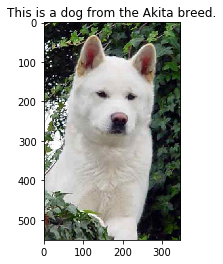

CPU times: user 646 ms, sys: 196 ms, total: 842 ms
Wall time: 339 ms


In [40]:
%%time
path = image_dir+'/test/004.Akita/Akita_00258.jpg'
run_app(path)

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

The results are as expected. The application correctly identifies human from animals, dogs from animals, and correctly estimates the dog breeds.

We do see three ways to improve the algorithm:

- Leverage CNN artifacts for human detector as it may generate a higher F1 score
- Identify a more lightweight CNN model for dog estimator as it is 90MB size
- Deploy this application onto a cloud platform (AWS / Google Cloud) to allow easy use and/or testing of real-time performance at a local, regional and/or global scale

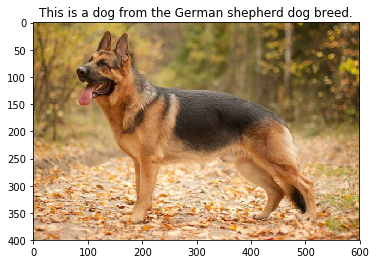

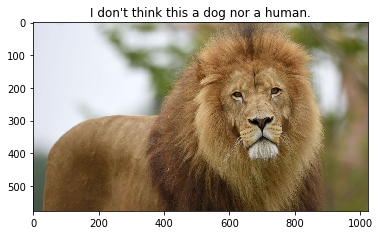

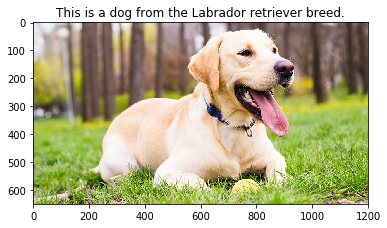

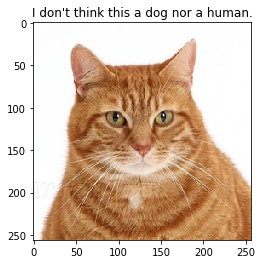

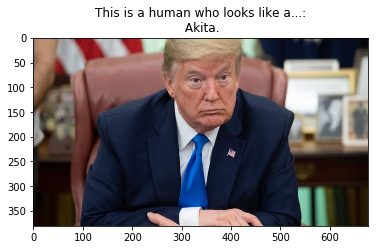

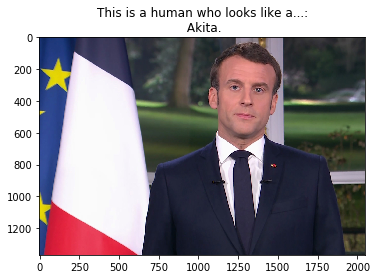

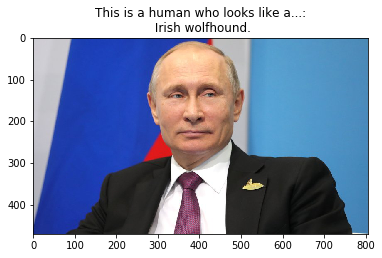

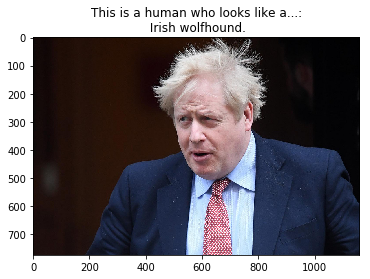

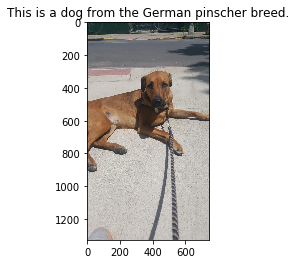

In [41]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.
  
real_case_files = np.array(glob("./real_data/*"))

for file in real_case_files:
    run_app(file)